# Werkje gegevensbanken 2018 - DEEL 04


## Inleiding

In dit document bespreken we de verschillende uitwerkingen en resultaten van het vierde deel van het project gegevensbanken. 
We zullen beginnen met het overlopen van de uitwerking van de optimalisatie. Vervolgens zullen we in het tweede onderdeel, de visualisatie, de uit de database verkregen data behandelen. 

 

## Basis code

Ter volledigheid van dit document voegen we hier ook de in de opgave gegeven basiscode, voor het uitvoeren van queries via Python, nog eens toe.

Ten eerste volgt hieronder de basiscode om de nodige packages in te laden:

In [59]:
# Benodigde packages
import json            # Package om .json files in te laden (bvb kolomnamen zijn zo opgeslagen)
import getpass         # Package om een paswoordveldje te genereren.
import mysql.connector # MySQL package
import numpy as np
import pandas as pd    # Populaire package voor data-verwerking
import sys
import os
import time
import matplotlib.pyplot as plt

Vervolgens definiëren we ook verschillende methodes om verbinding met de database te kunnen maken, ...

In [61]:
def verbind_met_GB(username, hostname, gegevensbanknaam):
    """
    Maak verbinding met een externe gegevensbank
    
    :param  username:          username van de gebruiker, string
    :param  hostname:          naam van de host, string.
                               Dit is in het geval van een lokale server gewoon 'localhost'
    :param  gegevensbanknaam:  naam van de gegevensbank, string.
    :return connection:        connection object, dit is wat teruggeven wordt 
                               door connect() methods van packages die voldoen aan de DB-API
    """
    
    password = getpass.getpass() # Genereer vakje voor wachtwoord in te geven
    
    connection = mysql.connector.connect(host=hostname,
                                         user=username,
                                         passwd=password,
                                         db=gegevensbanknaam)
    return connection

... een gegeven query uit te voeren om het resultaat daarvan terug te geven, ...

In [62]:
def run_query(connection, query):
    """
    Voer een query uit op een reeds gemaakte connectie, geeft het resultaat van de query terug
    """
    
    # Making a cursor and executing the query
    cursor = connection.cursor()
    cursor.execute(query)
    
    # Collecting the result and casting it in a pd.DataFrame
    res = cursor.fetchall()
    
    return res

... een gegeven query uit te voeren zonder een resultaat terug te geven, ...

In [63]:
def run_query_without_res(connection, query ) :
    # Making a cursor and executing the query
    cursor = connection.cursor()
    cursor.execute(query)
    

... een methode om de optimalisatie, die later in dit document aan bod komt, te kunnen controleren ...

In [64]:
def check_perfect_match(df1, df2):
    """
    Functie om te checken of 2 DataFrames gelijk zijn.
    """
    check = df1.equals(df2)
    return check

... en een methode om die resultaten om te vormen naar een pandas dataframe.

In [65]:
def res_to_df(query_result, column_names):
    """
    Giet het resultaat van een uitgevoerde query in een 'pandas dataframe'
    met vooraf gespecifieerde kolomnamen.
    
    Let op: Het resultaat van de query moet dus exact evenveel kolommen bevatten
    als kolomnamen die je meegeeft. Als dit niet het geval is, is dit een indicatie
    dat je oplossing fout is. (Gezien wij de kolomnamen van de oplossing al cadeau doen)
    
    """
    df = pd.DataFrame(query_result, columns=column_names)
    return df

Tot slot maken we verbinding met de gegevensbank en definiëren we nog enkele basisvariabelen voor dit deel van het project via onderstaande code:

In [66]:
username = 'root'      # Vervang dit als je via een andere user queries stuurt
hostname = 'localhost' # Als je een databank lokaal draait, is dit localhost.
db = 'lahman2016'      # Naam van de gegevensbank op je XAMPP Mysql server
c = verbind_met_GB(username, hostname, db)

········


In [67]:
column_names = ['state', 'avg_weight', 'avg_height', 'avg_homeruns', 'avg_saves']
col_nam = ['id', 'select_type', 'table', 'type' ,  'possible_keys', 'key', 'key_len', 'ref', 'rows', 'extra']

## Optimalisatie

In dit onderdeel zullen we stapsgewijs overlopen hoe onze geoptimaliseerde query tot stand is gekomen.

Ten eerste bekijken we de oorspronkelijke query, zonder enige vorm van optimalisatie. Hierbij focussen we vooral op de output van het SQL-statement EXPLAIN en de runtime van de code. Hiervoor hebben we enkele nieuwe functies nodig.

Hieronder volgt de oorspronkelijke query:

In [9]:
def query_to_optimize(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    # Actual query
    query="""
    SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
    FROM Master AS m,
        pitching AS pit,
        batting AS bat,
        hallOffame AS hof
    WHERE pit.yearID = {}
        AND bat.yearID = {}
        AND pit.playerID = m.playerID
        AND bat.playerID = m.playerID
        AND m.playerID = hof.playerID
        AND hof.yearID > {}
    GROUP BY m.birthState
    HAVING AVG(m.height) > {}
    ORDER BY m.birthState ASC;
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

Als ook het explain-statement:

In [10]:
def explain(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75) :
    query=""" EXPLAIN (
	        SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
            FROM Master AS m,
                 pitching AS pit,
                 batting AS bat,
                 hallOffame AS hof
            WHERE pit.yearID = {}
                  AND bat.yearID = {}
                  AND pit.playerID = m.playerID
                  AND bat.playerID = m.playerID
                  AND m.playerID = hof.playerID
                  AND hof.yearID > {}
            GROUP BY m.birthState
            HAVING AVG(m.height) > {}
            ORDER BY m.birthState ASC ) ; 
	 
	""".format(jaar_1, jaar_1, jaar_2, lengte)

    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

De code voor het bepalen van de tijdsduur zonder optimalisatie:

Het uitprinten van de resultaten van het explain-statement:

In [11]:
timings=[]
for i in range(10):
   t1 = time.time() # Start time
   df_orig = query_to_optimize(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
   t2 = time.time() # Stop time
   timings.append(t2-t1) 
   
orig_runtime=np.mean(timings) # De uiteindelijke runtime is een gemiddelde van 5 runs.
print(explain(c, col_nam) ) # explain before indexing 
print('De originele query duurt: ', "{0:.4f}".format(orig_runtime),' seconden')

   id select_type table type possible_keys   key key_len   ref    rows  \
0   1      SIMPLE   hof  ALL          None  None    None  None    4136   
1   1      SIMPLE     m  ALL          None  None    None  None   18962   
2   1      SIMPLE   pit  ALL          None  None    None  None   44628   
3   1      SIMPLE   bat  ALL          None  None    None  None  102125   

                                               extra  
0       Using where; Using temporary; Using filesort  
1    Using where; Using join buffer (flat, BNL join)  
2  Using where; Using join buffer (incremental, B...  
3  Using where; Using join buffer (incremental, B...  
De originele query duurt:  1.3590  seconden


Mogelijk resultaat:

   id select_type table type possible_keys   key key_len   ref    rows  
   
0   1      SIMPLE   hof  ALL          None  None    None  None    4136   
1   1      SIMPLE     m  ALL          None  None    None  None   19003   
2   1      SIMPLE   pit  ALL          None  None    None  None   44690   
3   1      SIMPLE   bat  ALL          None  None    None  None  102088   

                                               extra  
0       Using where; Using temporary; Using filesort  
1    Using where; Using join buffer (flat, BNL join)  
2  Using where; Using join buffer (incremental, B...  
3  Using where; Using join buffer (incremental, B...  
De originele query duurt:  1.6595  seconden


We analyseren nu de resultaten van het explain-statement. We zien dat, door een gebrek aan mogelijke indexen, SQL genoodzaakt wordt om alle tuples van alle relevante elementen te overlopen, beginnend bij de kleinste tabel halloffame. Met deze inefficiënte zoekstrategie heeft de query een redelijk hoge uitvoeringstijd nodig. 

### Eerste optimalisatie

We beginnen onze optimalisatie met toevoegen van een primary key op elk van de relevante tabellen:

In [12]:
def add_primary_key(connection ) :
    query1="""
    AlTER TABLE master ADD CONSTRAINT pk_master PRIMARY KEY (playerID)  ;
    """
    query2 = """
    ALTER TABLE batting ADD CONSTRAINT pk_batting PRIMARY KEY (playerID, stint, yearID, teamID);
    """
    query3 = """
    ALTER TABLE pitching ADD CONSTRAINT pk_pitching PRIMARY KEY (playerID, stint,  yearID, teamID);
    """
    query4="""
    ALTER TABLE hallOffame ADD CONSTRAINT pk_halloffame PRIMARY KEY (playerID, yearID, votedBy);
    """
    run_query_without_res(connection, query1) 
    run_query_without_res(connection, query2) 
    run_query_without_res(connection, query3)
    run_query_without_res(connection, query4)
    

Omdat de kolom playerID uit de tabellen batting en pitching verwijst naar de kolom playerID uit de tabel master, voegen we nog verwijssleutels toe op de tabellen batting en pitching: 

In [13]:
def add_foreign_keys(connection ):
    query1="""
    ALTER TABLE pitching ADD CONSTRAINT ref_1 FOREIGN KEY (playerID) REFERENCES master (playerID) ;  
    """
    query2="""
    ALTER TABLE batting ADD CONSTRAINT ref_2 FOREIGN KEY (playerID) REFERENCES master (playerID) ; 
    """  
    run_query_without_res(connection, query1) 
    run_query_without_res(connection, query2)

In principe verwijst ook de kolom playerID uit halloffame naar master. Echter, door inconsistenties in de database, kan deze verwijssleutel niet toegevoegd worden.

In [14]:
def optim_1(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    query="""
    SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
    FROM Master AS m,
        pitching AS pit,
        batting AS bat ,
        hallOffame AS hof  
    WHERE pit.yearID = {}
        AND bat.yearID = {}
        AND pit.playerID = m.playerID
        AND bat.playerID = m.playerID
        AND m.playerID = hof.playerID
        AND hof.yearID > {}
    GROUP BY m.birthState
    HAVING AVG(m.height) > {}
    ORDER BY m.birthState ASC;
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

We voeren de eerste optimalisatie uit:

In [15]:
add_primary_key(c) 
add_foreign_keys(c) 

KeyboardInterrupt: 

In [ ]:

print(explain(c, col_nam) )

timings_optim_1 = []
for i in range(10):
   t1 = time.time() # Start time
   df_optim_1 = optim_1(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
   t2 = time.time() # Stop time
   timings_optim_1.append(t2-t1) 
   
optim_1_runtime = np.mean(timings_optim_1) # Runtime optimalisatie 1

# Vergelijken met originele query
diff = orig_runtime-optim_1_runtime # Winst t.o.v. origineel
rel_diff = diff/orig_runtime # Relatieve winst
check = check_perfect_match(df_orig,df_optim_1) # Nagaan of de resultaten exact gelijk zijn.

# Belangrijkste resultaten printen.
print('De optimalisatie duurt: ', "{0:.2f}".format(optim_1_runtime),' seconden')
print('De originele versie duurde: ', "{0:.2f}".format(orig_runtime),' seconden')
print('De netto tijdwinst is dus: ',"{0:.2f}".format(diff),' seconden, oftewel', "{0:.2f}".format(100*rel_diff), '%' )
print('Is het resultaat equivalent? ', check)

Mogelijk resultaat: 

   id select_type table    type possible_keys      key key_len  \
   
   
0   1      SIMPLE   bat     ALL       PRIMARY     None    None   
1   1      SIMPLE   hof     ref       PRIMARY  PRIMARY     767   
2   1      SIMPLE     m  eq_ref       PRIMARY  PRIMARY     767   
3   1      SIMPLE   pit     ref       PRIMARY  PRIMARY     767   

                       ref  rows                                         extra  
0                     None     1  Using where; Using temporary; Using filesort  
1  lahman2016.bat.playerID     1                      Using where; Using index  
2  lahman2016.bat.playerID     1                                                
3  lahman2016.bat.playerID     2                                   Using where  
De optimalisatie duurt:  0.30  seconden
De originele versie duurde:  1.70  seconden
De netto tijdwinst is dus:  1.40  seconden, oftewel 82.24 %
Is het resultaat equivalent?  True


We merken op dat het invoeren van de indexen toch al een beduidende invloed heeft op de duur van het programma.
We zien dat op elke tabel de primary key gebruikt wordt, behalve op de tabel batting. Nochtans is dit de grootste tabel, die in deze query gebruikt wordt (zie resultaat eerste explain). Dit doet ons vermoeden dat het voordelig zou kunnen zijn om de index op batting te forceren.

### Tweede optimalisatie

We plaatsen het forceer statement: 

In [ ]:
def optim_2(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    query="""
    SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
    FROM Master AS m,
        pitching AS pit,
        batting AS bat FORCE INDEX (PRIMARY) ,
        hallOffame AS hof  
    WHERE pit.yearID = {}
        AND bat.yearID = {}
        AND pit.playerID = m.playerID
        AND bat.playerID = m.playerID
        AND m.playerID = hof.playerID
        AND hof.yearID > {}
    GROUP BY m.birthState
    HAVING AVG(m.height) > {}
    ORDER BY m.birthState ASC;
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

In [ ]:
def explain2(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75) :
    query=""" EXPLAIN (
	        SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
            FROM Master AS m,
                 pitching AS pit,
                 batting AS bat FORCE INDEX (primary),
                 hallOffame AS hof
            WHERE pit.yearID = {}
                  AND bat.yearID = {}
                  AND pit.playerID = m.playerID
                  AND bat.playerID = m.playerID
                  AND m.playerID = hof.playerID
                  AND hof.yearID > {}
            GROUP BY m.birthState
            HAVING AVG(m.height) > {}
            ORDER BY m.birthState ASC ) ; 
	 
	""".format(jaar_1, jaar_1, jaar_2, lengte)

    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

We bekijken het resultaat van de wijziging:

In [ ]:
print(explain2(c, col_nam) )

timings_optim_2 = []
for i in range(10):
   t1 = time.time() # Start time
   df_optim_2 = optim_2(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
   t2 = time.time() # Stop time
   timings_optim_2.append(t2-t1) 
   
optim_2_runtime = np.mean(timings_optim_2) # Runtime optimalisatie 1

# Vergelijken met originele query
diff = orig_runtime-optim_2_runtime # Winst t.o.v. origineel
rel_diff = diff/orig_runtime # Relatieve winst
check = check_perfect_match(df_orig,df_optim_2) # Nagaan of de resultaten exact gelijk zijn.

# Belangrijkste resultaten printen.
print('De optimalisatie duurt: ', "{0:.2f}".format(optim_2_runtime),' seconden')
print('De originele versie duurde: ', "{0:.2f}".format(orig_runtime),' seconden')
print('De netto tijdwinst is dus: ',"{0:.2f}".format(diff),' seconden, oftewel', "{0:.2f}".format(100*rel_diff), '%' )
print('Is het resultaat equivalent? ', check)

Een mogelijk resultaat:
    
       id select_type table    type possible_keys      key key_len  \
        
        
0   1      SIMPLE   hof   index       PRIMARY  PRIMARY    1538   
1   1      SIMPLE     m  eq_ref       PRIMARY  PRIMARY     767   
2   1      SIMPLE   bat     ref       PRIMARY  PRIMARY     767   
3   1      SIMPLE   pit     ref       PRIMARY  PRIMARY     767   

                       ref  rows  \
0                     None  4156   
1  lahman2016.hof.playerID     1   
2  lahman2016.hof.playerID     1   
3  lahman2016.hof.playerID     2   

                                               extra  
0  Using where; Using index; Using temporary; Usi...  
1                                                     
2                                        Using where  
3                                        Using where  
De optimalisatie duurt:  0.05  seconden
De originele versie duurde:  1.70  seconden
De netto tijdwinst is dus:  1.65  seconden, oftewel 96.84 %
Is het resultaat equivalent?  True

We zien dat het foceren van de index een duidelijk effect heeft op de tijdsduur van de query. Voor de kleinste tabel (halloffame) overloopt hij nu de volledig index, in plaats van de volledig tabel van batting. Vervolgens zoekt SQL per tupple in halloffame matches met behulp van de gedefiniëerde indexen. De volgorde waarin de tabellen overlopen worden is zo dat steeds het resultaat zo klein mogelijk is. 

### Derde optimalisatie

Om het overlopen van de tabel halloffame nog wat te verbeteren, kunnen we nog een index bouwen op de kolom yearID:

In [ ]:
def add_index(connection ):
    query="""
    CREATE INDEX ind1  ON hallOffame (yearID) ; 
    """
    run_query_without_res(connection, query) 

In [ ]:
def optim_3(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    query="""
    SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
    FROM Master AS m,
        pitching AS pit,
        batting AS bat  ,
        hallOffame AS hof  
    WHERE pit.yearID = {}
        AND bat.yearID = {}
        AND pit.playerID = m.playerID
        AND bat.playerID = m.playerID
        AND m.playerID = hof.playerID
        AND hof.yearID > {}
    GROUP BY m.birthState
    HAVING AVG(m.height) > {}
    ORDER BY m.birthState ASC;
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

Uitvoeren van de tweede optimalisatie:

In [ ]:
add_index(c)

In [ ]:
print(explain2(c, col_nam) )

timings_optim_3 = []
for i in range(10):
   t1 = time.time() # Start time
   df_optim_3 = optim_3(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
   t2 = time.time() # Stop time
   timings_optim_3.append(t2-t1) 
   
optim_3_runtime = np.mean(timings_optim_3) # Runtime optimalisatie 1

# Vergelijken met originele query
diff = orig_runtime-optim_3_runtime # Winst t.o.v. origineel
rel_diff = diff/orig_runtime # Relatieve winst
check = check_perfect_match(df_orig,df_optim_3) # Nagaan of de resultaten exact gelijk zijn.

# Belangrijkste resultaten printen.
print('De optimalisatie duurt: ', "{0:.2f}".format(optim_3_runtime),' seconden')
print('De originele versie duurde: ', "{0:.2f}".format(orig_runtime),' seconden')
print('De netto tijdwinst is dus: ',"{0:.2f}".format(diff),' seconden, oftewel', "{0:.2f}".format(100*rel_diff), '%' )
print('Is het resultaat equivalent? ', check)

Een mogelijk resultaat:

   id select_type table    type possible_keys      key key_len  \
   
0   1      SIMPLE   hof   range  PRIMARY,ind1     ind1       4   
1   1      SIMPLE     m  eq_ref       PRIMARY  PRIMARY     767   
2   1      SIMPLE   bat     ref       PRIMARY  PRIMARY     767   
3   1      SIMPLE   pit     ref       PRIMARY  PRIMARY     767   

                       ref  rows  \
0                     None   926   
1  lahman2016.hof.playerID     1   
2  lahman2016.hof.playerID     1   
3  lahman2016.hof.playerID     2   

                                               extra  
0  Using where; Using index; Using temporary; Usi...  
1                                                     
2                                        Using where  
3                                        Using where  
De optimalisatie duurt:  0.05  seconden
De originele versie duurde:  1.70  seconden
De netto tijdwinst is dus:  1.65  seconden, oftewel 97.21 %
Is het resultaat equivalent?  True

Met behulp van de net ingevoerde index dient het programma minder tuples te overlopen in de tabel halloffame. Daarnaast gebruikt hij nu automatisch de primary key op batting en hebben we het FORCE-statement verwijderd. 

### Verwijderen van de indexen voor herbruikbaarheid script en database 

In [ ]:
def drop_index(	connection ):
    query_drop_fk2="""
	ALTER TABLE batting DROP FOREIGN KEY ref_2 ;  
	"""

    query_drop_fk1="""
	AlTER TABLE pitching DROP FOREIGN KEY ref_1 ; 
	"""

    query_drop_pk="""
	ALTER TABLE master DROP PRIMARY KEY ; 
	"""	
    query_drop_ind1="""
	ALTER TABLE hallOffame DROP INDEX ind1 ; 
	"""

    query_drop_pk2 = """
        ALTER TABLE pitching DROP PRIMARY KEY ;
        """


    query_drop_pk3="""
        ALTER TABLE batting DROP PRIMARY KEY;
        """
    query_drop_pk4="""
	ALTER TABLE hallOffame DROP PRIMARY KEY;
	"""


    
    run_query_without_res(connection,query_drop_fk2)
    run_query_without_res(connection,query_drop_fk1) 
    run_query_without_res(connection, query_drop_pk)
    run_query_without_res(connection, query_drop_ind1)
    run_query_without_res(connection, query_drop_pk2)
    run_query_without_res(connection, query_drop_pk3)
    run_query_without_res(connection, query_drop_pk4)

In [ ]:
drop_index(c) 

## Visualisatie

Voor het onderdeel visualisatie, vragen we ons af wat de gemiddelde leeftijd van de beste batters is op het moment dat ze het beste presteren.
Om dit uit te zoeken maakten we verschillende queries. Voor onze eerste queries namen we aan dat de beste batters gedefinieerd konden worden door te kijken wie in de tabel halloffame was geïntroduceerd. 

We bekeken dit eerst per staat: onze query kijkt op welke leeftijd een batter het meeste homeruns geslagen heeft, en vergelijkt het gemiddelde hiervan per geboortestaat. Opmerking hierbij dat onze query wel degelijk enkel rekening houdt met de batters die in de tabel halloffame zijn opgenomen:

In [26]:

def visualizeTHIS(connection, visualize_cols):
    query="""
    SELECT m.birthState, AVG(b.yearID - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID, max(HR) FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
     JOIN halloffame H ON M.playerID = H.playerID
    WHERE H.inducted = "Y"
    GROUP BY m.birthState;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	
	
username = 'root'      # Vervang dit als je via een andere user queries stuurt
hostname = 'localhost' # Als je een databank lokaal draait, is dit localhost.
db = 'lahman2016'      # Naam van de gegevensbank op je XAMPP Mysql server

# We verbinden met de gegevensbank
c = verbind_met_GB(username, hostname, db)
column_names = ['state', 'avg_weight', 'avg_height', 'avg_homeruns', 'avg_saves']
col_nam = ['id', 'select_type', 'table', 'type' ,  'possible_keys', 'key', 'key_len', 'ref', 'rows', 'extra']

visualize_cols = ['State', 'TopPerformance']


plt.figure(1)
df = visualizeTHIS(c, visualize_cols)
df['A'] = pd.Series(list(range(len(df))))
df=df.astype({'TopPerformance':float}) #FOR SOME REASON IT NEEDS THIS !!!!!!!!!!!!!!!!!!
df=df.astype({'State':str})
ax = df['TopPerformance'].plot.bar(color=[np.random.rand(3,1) for i in range(len(df))])
ax.set_xlabel('Birth State')
ax.set_ylabel('Age of best performance')
ax.set_xticklabels(df.State)
plt.show()

········


Het extreem lage resultaat van de staat Idaho kan verklaart worden doordat er maar één batter is uit Idaho die in de tabel halloffame staat.

We keken ook of er een duidelijke trend was tussen het jaar en de leeftijd van de batters:

In [27]:
#Visualisation nr 2
def visualizeTHIS2(connection, visualize_cols):
    query="""
    SELECT m.birthYear, AVG(b.yearID - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID, max(HR) FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
     JOIN halloffame H ON M.playerID = H.playerID
    WHERE H.inducted = "Y" AND m.birthYear < 1995 AND m.birthYEAR > 1800
    GROUP BY m.birthYear;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	

plt.figure(2)
cols2 = ['Year', 'Age']
df = visualizeTHIS2(c, cols2)
df=df.astype({'Age':float})
df=df.astype({'Year':float})
df.plot(x = 'Year', y = 'Age')

plt.show()

Uit deze gegevens valt geen duidelijk trend op te maken, hierdoor hebben we beslist om ook te kijken naar de batters die genomineerd werden voor de halloffame:

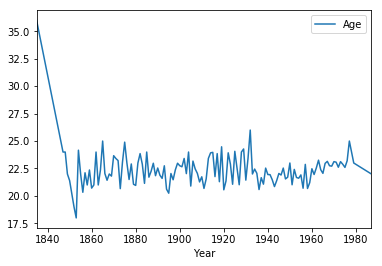

In [28]:
def visualizeTHIS3(connection, visualize_cols):
    query="""
    SELECT m.birthYear, AVG(b.yearID - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID, max(HR) FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
     JOIN halloffame H ON M.playerID = H.playerID
    WHERE m.birthYear < 1995 AND m.birthYEAR > 1800
    GROUP BY m.birthYear;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	

plt.figure(2)
cols2 = ['Year', 'Age']
df = visualizeTHIS3(c, cols2)
df=df.astype({'Age':float})
df=df.astype({'Year':float})
df.plot(x = 'Year', y = 'Age')
plt.show()

Om nog meer data te vinden, besloten we dan maar om alle spelers toe te voegen:

In [29]:
def visualizeTHIS4(connection, visualize_cols):
    query="""
    SELECT m.birthYear, AVG(b.yearID - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID, max(HR) FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
    WHERE m.birthYear < 1995 AND m.birthYEAR > 1800
    GROUP BY m.birthYear;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	

plt.figure(2)
cols2 = ['Year', 'Age']
df = visualizeTHIS4(c, cols2)
df=df.astype({'Age':float})
df=df.astype({'Year':float})
df.plot(x = 'Year', y = 'Age')
plt.show()

Uit deze grafiek blijkt dat, met uitzondering van de beginjaren binnen deze database, wat misschien kan verweten worden aan een gebrek van data points, de gemiddelde leeftijd waarop batters het best performeren niet veel veranderd is over de jaren heen. De vermindering op het einde komt ook weer door een tekort aan data, aangezien het jaar gegeven afhankelijk is van de geboortedatum, en sommige batters in de database nog niet hun hoogste aantal homeruns bereikt hebben.
Daarom nam ik een andere maat van leeftijd van spelers, namelijk het gemiddelde van de datum waarop ze begonnen zijn met spelen en de datum waarop ze gestopt zijn.

In [30]:
def visualizeTHIS5(connection, visualize_cols):
    query="""
    SELECT m.birthYear, AVG((year(finalGame) + year(debut))/2 - m.birthYear  )
    FROM master m
    WHERE m.birthYear < 1990 AND m.birthYEAR > 1800
    GROUP BY m.birthYear
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	


plt.figure(2)
cols2 = ['Year', 'Age']
df = visualizeTHIS5(c, cols2)
df=df.astype({'Age':float})
df=df.astype({'Year':float})
df.plot(x = 'Year', y = 'Age')

plt.show()

Als we deze nu samen plotten:

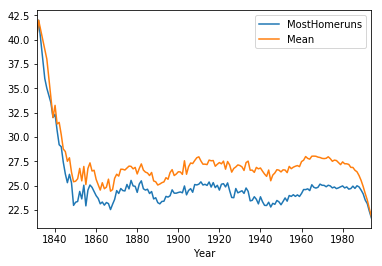

In [31]:
def visualizeTHIS6(connection, visualize_cols):
    query="""
    SELECT m.birthYear, AVG(b.yearID - m.birthYear), AVG((year(finalGame) + year(debut))/2 - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID, max(HR) FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
    WHERE m.birthYear < 1995 AND m.birthYEAR > 1800
    GROUP BY m.birthYear;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	

plt.figure(2)
cols2 = ['Year', 'MostHomeruns', 'Mean']
df = visualizeTHIS6(c, cols2)
df=df.astype({'MostHomeruns':float})
df=df.astype({'Year':float})
df=df.astype({'Mean':float})
df = df.set_index('Year')
df.plot()
plt.show()

Dit wijst wel op een interessant resultaat: Gemiddeld gezien halen batters de meeste homeruns in het begin van hun carriëre, ongeveer 2 jaar voor dat ze het midden van hun carriëre bereikt hebben.

Kunnen we zien dat er een statistisch significant verschil is tussen de leeftijd waarop het meeste aantal homeruns geslagen worden en de gemiddelde leeftijd van een baseballspeler?

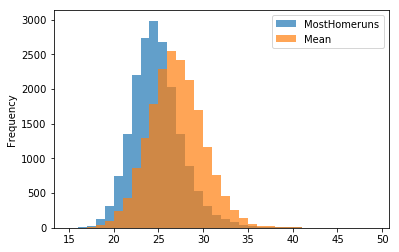

In [32]:
def visualizeTHIS8(connection, visualize_cols):
    query="""
    SELECT (b.yearID - m.birthYear), ((year(finalGame) + year(debut))/2 - m.birthYear)
    FROM (master m JOIN (SELECT playerID, yearID FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
    WHERE m.birthYear < 1995 AND m.birthYEAR > 1800;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	

plt.figure(2)
cols2 = ['MostHomeruns', 'Mean']
df = visualizeTHIS8(c, cols2)
df=df.astype({'MostHomeruns':float})
df=df.astype({'Mean':float})
df.plot.hist(alpha = 0.7, bins = range(15,50), stacked = False)

plt.show()

Zonder een statistische oplossing te geven (dit is een Behrens-Fisher probleem en kan zo opgelost worden), kunnen we dan
uit de grafiek duidelijk zien dat spelers wel degelijk eerst hun jaar van de meeste homeruns bereiken en dan pas het punt halverwege hun carriëre.

Conclusie: Managers zouden beter hun batters vroeger de laan uit sturen, want voor de meeste batters geldt dat ze het best performeren wanneer ze nog jong zijn!

In [90]:
def visualizeTHIS9(connection, visualize_cols):
    query="""
    SELECT ((year(finalGame) - year(debut)))
    FROM (master m JOIN (SELECT playerID, yearID FROM Batting GROUP BY playerID) b ON m.playerID = b.playerID)
    WHERE m.birthYear < 1995 AND m.birthYEAR > 1800;
    """
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df =  res_to_df(res, visualize_cols)         # Query in DataFrame brengen
    return df	
x = np.linspace(0,40, 400)
plt.figure(2)
cols2 = ['CareerLength']
df = visualizeTHIS9(c, cols2)
lambda1 = 1/df['CareerLength'].mean()
lambda2 = 1/np.sqrt(df['CareerLength'].var())
lambd = (lambda1 + lambda2) / 2
print(lambda1, lambda2)
df=df.astype({'CareerLength':float})
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df['CareerLength'].dropna(), range = (0, 30), normed = True)
y = lambd* np.exp(- lambd * x)
ax.plot(x, y)

fig.tight_layout()


plt.show()

0.21063851271752182 0.19940969672


## Figures van visualisatie

![States vs. Average Age](img/StateVSAge.png)

![Years vs. Average Age](img/YearVSAge.png)

![](img/Figure3.png)

![](img/Figure4.png)

![](img/Figure5.png)

![](img/Figure6.png)

![](img/Figure7.png)